In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import sys

import layers_v2 as layers
import util as util
import networks as networks
import distributions

torch.set_default_dtype(torch.float64)

In [45]:
sys.path.insert(0, '../exp/')
import util as util_data

In [46]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
importlib.reload(distributions)

<module 'distributions' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/distributions.py'>

### Test LogitNormal

In [4]:
m = distributions.LogitNormal(torch.tensor([0.0]), torch.tensor([1.0]))
m.sample()

tensor([0.4725])

In [5]:
m1 = distributions.LogitNormal(torch.tensor([0.0]), torch.tensor([1.0]))
m2 = distributions.LogitNormal(torch.tensor([1.0]), torch.tensor([2.0]))

torch.distributions.kl_divergence(m1, m2)

tensor([0.4431])

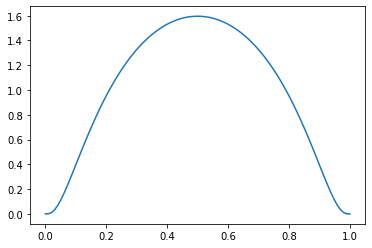

In [17]:
logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))

eps = .0001
x = np.linspace(0+eps,1-eps,100)
plt.plot(x, logitnormal_pdf(x,0,1))

### Temp

In [20]:
a = nn.Parameter(torch.tensor(1.0))
b = a
a.data = torch.tensor(2.0)
b

Parameter containing:
tensor(2., requires_grad=True)

In [25]:
a = nn.Parameter(torch.tensor(1.0))
m = torch.distributions.normal.Normal(a, torch.tensor(3.0))
a.data = torch.tensor(2.0)
m.loc

Parameter containing:
tensor(2., requires_grad=True)

In [37]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.distributions.transforms.AbsTransform()
b = t(a)
a.data = torch.tensor(-2.0)
b

tensor(1., grad_fn=<AbsBackward>)

In [46]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.nn.Softplus()
b = t(a)
print(b)
a.data = torch.tensor(-2.0)
print(b)
print(t(a))

tensor(0.3133, grad_fn=<SoftplusBackward>)
tensor(0.3133, grad_fn=<SoftplusBackward>)
tensor(0.1269, grad_fn=<SoftplusBackward>)


In [29]:
b

tensor(1., grad_fn=<AbsBackward>)

In [57]:
loc = nn.Parameter(torch.tensor(0.0))
scale = nn.Parameter(torch.tensor(1.0))

loss = (1.0 - (loc + torch.randn(1)*scale))**2
loss.backward()
loc.grad

tensor(-2.4578)

In [59]:
loc = nn.Parameter(torch.tensor(0.0))
scale = nn.Parameter(torch.tensor(1.0))

m = torch.distributions.normal.Normal(loc,scale)

loss = (1.0 - m.rsample())**2
loss.backward()
loc.grad

tensor(-3.9945)

In [71]:
m = torch.distributions.normal.Normal(torch.tensor(0.0),torch.tensor(-100.0))
m.sample()

tensor(-17.6694)

In [88]:
torch.normal(torch.tensor(0.), torch.tensor(-1000.))

tensor(1120.5515)

In [90]:
torch.distributions.normal.Normal.arg_constraints['scale']

GreaterThan(lower_bound=0.0)

In [97]:
transform_to = torch.distributions.constraint_registry.ConstraintRegistry()

@transform_to.register(torch.distributions.constraints.positive)
def _transform_to_positive(constraint):
    return torch.distributions.transforms.ExpTransform()

In [99]:
constraint = torch.distributions.normal.Normal.arg_constraints['scale']
scale = transform_to(constraint)(torch.zeros(1))  # constrained
u = transform_to(constraint).inv(scale)

In [106]:
a = nn.Parameter(torch.tensor(-1.0))
scale = transform_to(constraint)(a)  # constrained
print(a)
print(torch.log(scale))
a.data = torch.tensor(-2.0)
print(a)
print(torch.log(scale))

Parameter containing:
tensor(-1., requires_grad=True)
tensor(-1., grad_fn=<LogBackward>)
Parameter containing:
tensor(-2., requires_grad=True)
tensor(-1., grad_fn=<LogBackward>)


In [ ]:
a = nn.Parameter(torch.tensor(-1.0))
t = torch.distributions.transforms.AbsTransform()
b = t(a)
a.data = torch.tensor(-2.0)
b

### SIN dataset

In [47]:
n_obs = 100
dim_in = 2
Z, X, Y, sig2 = util_data.load_data('sin', n_obs=n_obs, dim_in=dim_in, sig2=.01, seed=0)


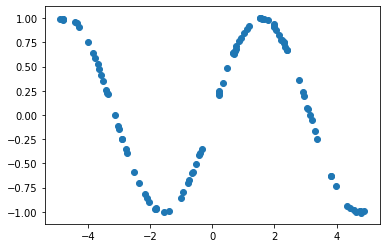

In [48]:
plt.scatter(Z[:,0],Y)

In [82]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)
importlib.reload(distributions)

<module 'distributions' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/distributions.py'>

In [83]:
# logitnormal
torch.manual_seed(2)
model = networks.RffHs(dim_in, 1, dim_hidden=50, sig2_inv=1/sig2, \
                       layer_in_name='RffVarSelectLogitNormalLayer',\
                       s_loc_prior=0.5,
                       s_scale_prior=1.0)


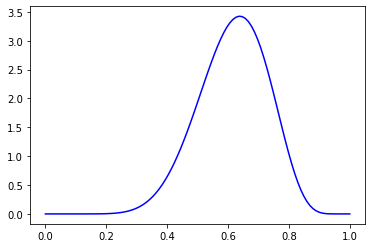

In [31]:
eps = .0001
x = np.linspace(0+eps,1-eps,100)

logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))


loc = model.layer_in.s_loc_prior.item()
scale = model.layer_in.s_loc_prior.item()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='blue',label='s0')

In [38]:
# beta
torch.manual_seed(2)
model = networks.RffHs(dim_in, 1, dim_hidden=50, sig2_inv=1/sig2, \
                       layer_in_name='RffVarSelectBetaLayer',\
                       s_a_prior=3,
                       s_b_prior=2)

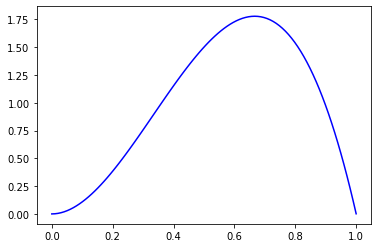

In [39]:
eps = .0001
x = np.linspace(0+eps,1-eps,100)
import scipy

a = model.layer_in.s_a_prior.item()
b = model.layer_in.s_b_prior.item()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='blue',label='s0')


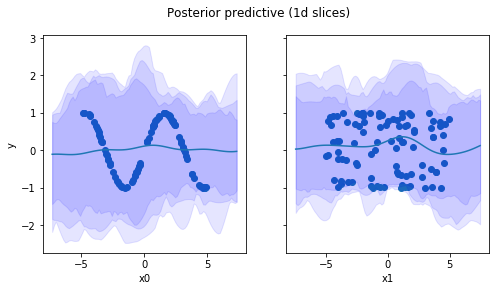

In [40]:
def sample_f_prior(x):
    with torch.no_grad():
        return model.forward(torch.from_numpy(x), weights_type_layer_in='sample_prior', weights_type_layer_out='sample_prior')

fig, ax = util.plot_slices(sample_f_prior, Z, Y, quantile=.5, n_samp=50, figsize=(4*2,4))


In [41]:
torch.manual_seed(2)
#optimizer = torch.optim.Adam(model.parameters(), lr=.001)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
model.reinit_parameters(torch.from_numpy(Z),torch.from_numpy(Y),n_reinit=10) 


In [42]:
for name, p in model.named_parameters():
    print(name, p.detach())

layer_in.s_a_trans tensor([1.0013, 1.0061])
layer_in.s_b_trans tensor([0.9967, 1.0084])


In [277]:
q = model.layer_in.get_variational()

In [286]:
q.sample((3,)).shape

torch.Size([3, 2])

In [285]:
q.sample().shape

torch.Size([2])

In [296]:
D = 2 # dimension of input
K = 3 # number of hidden units
N = 4 # number of observations
S = 1 # number of samples from q

s = torch.ones((S,D))
w = torch.ones((K,D))
x = torch.ones((N,D))

xs = x.unsqueeze(1) * s.unsqueeze(0)

torch.squeeze(F.linear(xs,w)).shape

torch.Size([4, 3])

In [289]:
x.unsqueeze(1).shape

torch.Size([4, 1, 2])

In [294]:
s.unsqueeze(0).shape

torch.Size([1, 5, 2])

In [79]:
s.view(1,1,-1).

torch.Size([1, 1, 2])

In [76]:
x.shape

torch.Size([3, 1])

In [84]:
x = torch.tensor([[1], [2], [3]])

x.expand(-1, 4)

tensor([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]])

In [77]:
x.expand(3, 4).shape

torch.Size([3, 4])

In [72]:
x = torch.tensor([[1,2,3]])
x.expand(3,1)

RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [3, 1].  Tensor sizes: [1, 3]

In [297]:
# dimensions of m are observations
N = 5 # number of observations
S = 2 # number of samples from q
D = 1 # output dimension

loc = torch.randn((N,S,D)) # network output
scale = torch.tensor(1.0)

m = torch.distributions.normal.Normal(loc, scale)
[m.batch_shape, m.event_shape]

[torch.Size([5, 2, 1]), torch.Size([])]

In [308]:
data = torch.ones((N,D))
m.log_prob(data.unsqueeze(1)).shape

torch.Size([5, 2, 1])

In [309]:
m.log_prob(data.unsqueeze(1))

tensor([[[-0.9855],
         [-2.0768]],

        [[-2.0024],
         [-0.9379]],

        [[-4.9539],
         [-1.4323]],

        [[-1.2106],
         [-3.7649]],

        [[-4.0840],
         [-1.4917]]])

In [303]:
m.log_prob(data.unsqueeze(1)).mean(1).sum(0)

tensor([-11.4700])

In [301]:
diagm = torch.distributions.independent.Independent(m,1)
[diagm.batch_shape, diagm.event_shape]

[torch.Size([5, 2]), torch.Size([1])]

In [270]:
data = torch.ones((N,S,D))
diagm.log_prob(data)

tensor([-3.5973, -5.4053, -3.3917, -3.4972, -4.3453])

In [224]:
# dimensions of m are observations
loc = torch.tensor([0.,0.])
scale = torch.tensor(1.0)

m = torch.distributions.normal.Normal(loc.view(-1), scale)
[m.batch_shape, m.event_shape]

[torch.Size([2]), torch.Size([])]

In [233]:
S = 5
y=torch.randn(S, 2) 
y

tensor([[ 0.1994, -1.3322],
        [ 0.3696, -0.4417],
        [ 1.0378,  0.1359],
        [ 0.0681, -1.8377],
        [-0.8369, -0.9166]])

In [234]:
m.log_prob(y)

tensor([[-0.9388, -1.8063],
        [-0.9872, -1.0165],
        [-1.4574, -0.9282],
        [-0.9213, -2.6076],
        [-1.2691, -1.3390]])

In [168]:
m.log_prob(y)

tensor([[-0.9634],
        [-0.9775]])

In [229]:
m.log_prob(y).mean(0).sum()

tensor(-2.1879)

In [152]:
y=torch.randn(2) # first dimension could be anything (like samples), second dimension is observations
y

tensor([0.4247, 0.7341])

In [154]:
m.log_prob(y.reshape(-1,1))

tensor([[-1.0091, -1.0091],
        [-1.1884, -1.1884]])

In [156]:
y.reshape(-1,1).shape

torch.Size([2, 1])

In [43]:
elbo = -networks.train(model, optimizer, torch.from_numpy(Z), torch.from_numpy(Y), n_epochs=1000, n_rep_opt=100, print_freq=1)
plt.plot(-elbo)

Epoch[1/1000], kl: 3.050004, likelihood: -22693.579146, elbo: -22935.835146
Epoch[2/1000], kl: 13.794821, likelihood: -2489.607456, elbo: -2477.544470
Epoch[3/1000], kl: 15.144655, likelihood: -2454.934210, elbo: -2478.862202
Epoch[4/1000], kl: 15.706383, likelihood: -2599.089872, elbo: -4035.040206
Epoch[5/1000], kl: 24.689842, likelihood: -2935.286137, elbo: -2828.304801
Epoch[6/1000], kl: 31.097433, likelihood: -2806.236798, elbo: -2723.773770
Epoch[7/1000], kl: 35.856251, likelihood: -2502.200256, elbo: -2592.934763
Epoch[8/1000], kl: 36.119682, likelihood: -13746.663947, elbo: -13679.592926
Epoch[9/1000], kl: 45.367174, likelihood: -4369.680860, elbo: -8919.735623
Epoch[10/1000], kl: 81.981834, likelihood: -2500.753650, elbo: -2599.401830
Epoch[11/1000], kl: 85.701607, likelihood: -2413.421085, elbo: -2606.072327
Epoch[12/1000], kl: 88.187250, likelihood: -3016.929060, elbo: -3150.921600
Epoch[13/1000], kl: 101.072042, likelihood: -2611.189411, elbo: -2804.510279
Epoch[14/1000], k

KeyboardInterrupt: 

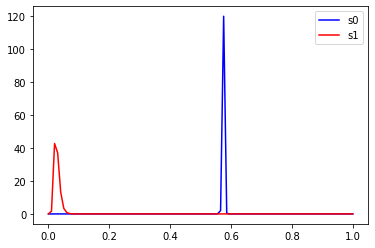

In [26]:
# logitnormal
eps = .0001
x = np.linspace(0+eps,1-eps,100)

logit = lambda x: np.log(x/(1-x))

def logitnormal_pdf(x, mu=0, sig2=1):
    return 1/np.sqrt(2*np.pi*sig2)/(x*(1-x))*np.exp(-(logit(x)-mu)**2/(2*sig2))


loc = model.layer_in.s_loc[0].detach().numpy()
scale = model.layer_in.transform(model.layer_in.s_scale_untrans[0]).detach().numpy()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='blue',label='s0')

loc = model.layer_in.s_loc[1].detach().numpy()
scale = model.layer_in.transform(model.layer_in.s_scale_untrans[1]).detach().numpy()
plt.plot(x, logitnormal_pdf(x,loc,scale**2), color='red',label='s1')
plt.legend()


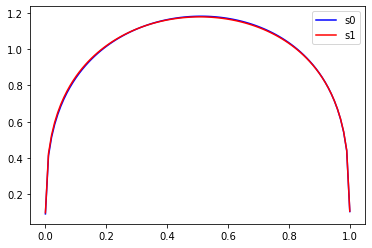

In [307]:
# beta
eps = .0001
x = np.linspace(0+eps,1-eps,100)
import scipy

a = model.layer_in.untransform(model.layer_in.s_a_trans[0]).detach().numpy()
b = model.layer_in.untransform(model.layer_in.s_b_trans[0]).detach().numpy()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='blue',label='s0')

a = model.layer_in.untransform(model.layer_in.s_a_trans[1]).detach().numpy()
b = model.layer_in.untransform(model.layer_in.s_b_trans[1]).detach().numpy()
plt.plot(x, scipy.stats.beta.pdf(x,a,b), color='red',label='s1')

plt.legend()


In [28]:
def sample_f_post(x_test, x_train=torch.from_numpy(Z), y_train=torch.from_numpy(Y)):
    # inputs and outputs are numpy arrays
    #return model(torch.from_numpy(x), weights_type_layer_in='sample_post', weights_type_layer_out='sample_post').detach().numpy()

    # sample from variational dist then sample weights (conjugate)
    #model.fixed_point_updates(torch.from_numpy(Z),torch.from_numpy(Y)) 
    
    #return model(torch.from_numpy(x), weights_type_layer_in='stored', weights_type_layer_out='stored').detach().numpy()

    with torch.no_grad():
        return model.sample_posterior_predictive(x_test=torch.from_numpy(x_test), x_train=x_train, y_train=y_train).numpy().reshape(-1)


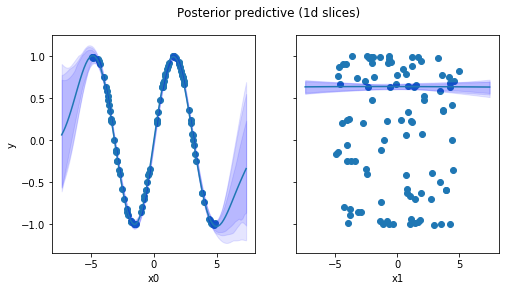

In [29]:
fig, ax = util.plot_slices(sample_f_post, Z, Y, quantile=.5, n_samp=50, figsize=(4*2,4))


#### GPy for comparison

In [29]:
import GPy
kernel = GPy.kern.RBF(input_dim=2, variance=1., lengthscale=1.)

In [30]:
m = GPy.models.GPRegression(Z,Y,kernel)

m.Gaussian_noise.variance = sig2
m.Gaussian_noise.fix()
m.optimize_restarts(num_restarts = 10, verbose=False)

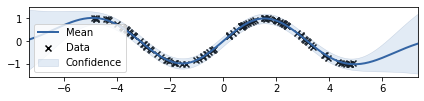

In [41]:
slices = [0]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=True)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

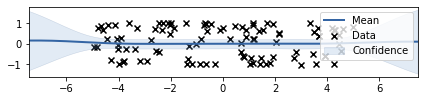

In [42]:
slices = [0]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=True)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')